<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Pickled-Data" data-toc-modified-id="Pickled-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pickled Data</a></span></li><li><span><a href="#Keras-Data" data-toc-modified-id="Keras-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Keras Data</a></span></li><li><span><a href="#Visualize-Original-Image" data-toc-modified-id="Visualize-Original-Image-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Visualize Original Image</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Classifier" data-toc-modified-id="Classifier-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classifier</a></span><ul class="toc-item"><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></li><li><span><a href="#Tuning-Each-Run" data-toc-modified-id="Tuning-Each-Run-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tuning Each Run</a></span></li><li><span><a href="#Hyperparameters-Tuning-by-Grid-Search" data-toc-modified-id="Hyperparameters-Tuning-by-Grid-Search-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hyperparameters Tuning by Grid Search</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

In [1]:
# import libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from time import time as runtime
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
%matplotlib inline

## Load Data

### Pickled Data

In [15]:
# unpickled data batch
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

def load_data(file):
    data_dic = unpickle(file)
    labels = data_dic[b'labels']
    data = data_dic[b'data']
    return labels, data

In [3]:
# load label description
label_desc = unpickle("batches.meta")
label_names = label_desc[b'label_names']
# load test data
test_labels, test_data = load_data("test_batch")
# load train data
train_labels = []
train_data = np.zeros((50000, 3072))
for i in range(5):
    filename = "data_batch_" + str(i+1)
    labels, data = load_data(filename)
    train_labels.extend(labels)
    train_data[i*10000:(i+1)*10000, :] = data

In [16]:
label_desc = unpickle("batches.meta")

In [18]:
label_names = label_desc['label_names']

In [19]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Keras Data

In [2]:
from keras.datasets import cifar10
# load data
(train_X, train_Y_labels), (test_X, test_Y_labels) = cifar10.load_data()

E:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


170500096/170498071 [==============================] - 181s 1us/step


In [3]:
# reshape data
train_data = train_X.reshape((50000, 3072))
train_labels = list(train_Y_labels.flatten())
test_data = test_X.reshape((10000, 3072))
test_labels = list(test_Y_labels.flatten())

### Visualize Original Image

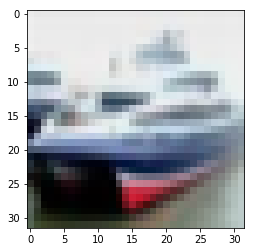

In [54]:
# visualize the original image
vis = test_data[1].reshape(3, 32, 32)
plt.imshow(np.transpose(vis, (1, 2, 0)), interpolation='none')

## PCA

In [89]:
t0 = runtime()
pca = PCA(n_components=100)
pca.fit(train_data)
print("Model built. Runtime: %.1f" % (runtime()-t0))

Model built. Runtime: 11.2


In [90]:
t0 = runtime()
train_pca = pca.transform(train_data)
test_pca = pca.transform(test_data)
print("Model built. Runtime: %.1f" % (runtime()-t0))

Model built. Runtime: 1.5


## Classifier

### Decision Tree

In [91]:
t0 = runtime()
model_dt = DecisionTreeClassifier()
model_dt = model_dt.fit(train_pca, train_labels)
print("Model built. Runtime: %.1fs." % (runtime()-t0))

Model built. Runtime: 12.0 s.


In [93]:
# prediction
pred_dt = model_dt.predict(test_pca)
sum(pred_dt == test_labels)

2720

### Random Forest

In [94]:
t0 = runtime()
model_rf = RandomForestClassifier(n_estimators=50)
model_rf = model_rf.fit(train_pca, train_labels)
print("Model built. Runtime: %.1fs" % (runtime()-t0))

Model built. Runtime: 34.8s


In [95]:
# prediction
pred_rf = model_rf.predict(test_pca)
sum(pred_rf == test_labels)

4370

## Tuning Each Run

In [5]:
# split training set into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [8]:
# hyper parameters
random.seed(1234)
d=130
n=1000

In [9]:
# pca and classifier
print("Number of reduced dimensions:", d)
print("Number of trees:", n)
t0=runtime()
pca = PCA(n_components=d)
pca.fit(X_train)
train_pca = pca.transform(X_train)
test_pca = pca.transform(X_test)
t1=runtime()
print("PCA finished. Runtime: %.1fs." % (t1-t0))
model_rf = RandomForestClassifier(n_estimators=n)
model_rf = model_rf.fit(train_pca, y_train)
t2=runtime()
print("Random Forest fitted. Runtime: %.1fs." % (t2-t1))
pred_rf = model_rf.predict(test_pca)
acc = sum(pred_rf == y_test)/100
print("Accuracy: %.2f%%" % acc)
print("Total runtime: %.1fs." % (runtime()-t0))

Number of reduced dimensions: 130
Number of trees: 1000
PCA finished. Runtime: 23.1s.
Random Forest fitted. Runtime: 599.3s.
Accuracy: 49.14%
Total runtime: 626.3s.


## Hyperparameters Tuning by Grid Search

In [4]:
# pipeline pca and classifier
model_rf = RandomForestClassifier()
pca_rf = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier())])
param_grid_rf = [{
                'pca__n_components': [50, 70, 100, 130, 150],
                'rf__n_estimators': [300, 400, 500, 700, 1000]
                }]


#parameters_rf = {'pca__n_components':[10, 100, 500, 1000, 2000], 'rf__n_estimators':[10, 50, 70, 100, 130]}
grid_cv_rf = GridSearchCV(estimator=pca_rf, cv=5, param_grid=param_grid_rf)

In [ ]:
t0 = runtime()
grid_cv_rf.fit(train_data, train_labels)
print("Model built. Runtime: %.1fs" % (runtime()-t0))

In [128]:
grid_cv_rf.cv_results_['mean_test_score']

array([ 0.31832,  0.37222,  0.3785 ,  0.38064,  0.38382,  0.30752,
        0.4149 ,  0.43066,  0.44502,  0.45394,  0.23484,  0.342  ,
        0.36406,  0.38458,  0.40006,  0.20688,  0.30338,  0.3235 ,
        0.352  ,  0.36308,  0.18984,  0.2715 ,  0.28408,  0.31006,  0.32308])

In [129]:
grid_cv_rf.cv_results_['params']

({'pca__n_components': 10, 'rf__n_estimators': 10},
 {'pca__n_components': 10, 'rf__n_estimators': 50},
 {'pca__n_components': 10, 'rf__n_estimators': 70},
 {'pca__n_components': 10, 'rf__n_estimators': 100},
 {'pca__n_components': 10, 'rf__n_estimators': 130},
 {'pca__n_components': 100, 'rf__n_estimators': 10},
 {'pca__n_components': 100, 'rf__n_estimators': 50},
 {'pca__n_components': 100, 'rf__n_estimators': 70},
 {'pca__n_components': 100, 'rf__n_estimators': 100},
 {'pca__n_components': 100, 'rf__n_estimators': 130},
 {'pca__n_components': 500, 'rf__n_estimators': 10},
 {'pca__n_components': 500, 'rf__n_estimators': 50},
 {'pca__n_components': 500, 'rf__n_estimators': 70},
 {'pca__n_components': 500, 'rf__n_estimators': 100},
 {'pca__n_components': 500, 'rf__n_estimators': 130},
 {'pca__n_components': 1000, 'rf__n_estimators': 10},
 {'pca__n_components': 1000, 'rf__n_estimators': 50},
 {'pca__n_components': 1000, 'rf__n_estimators': 70},
 {'pca__n_components': 1000, 'rf__n_estima

In [130]:
pca_rf2 = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier())])
param_grid_rf2 = {
                'pca__n_components': [20, 30, 50, 80],
                'rf__n_estimators': [120, 140, 150]
                }
grid_cv_rf2 = GridSearchCV(estimator=pca_rf2, cv=3, param_grid=param_grid_rf2)

In [131]:
t0 = runtime()
grid_cv_rf2.fit(train_data, train_labels)
print("Model built. Runtime: %.1fs" % (runtime()-t0))

Model built. Runtime: 3029.0s


In [132]:
grid_cv_rf2.cv_results_['mean_test_score']

array([ 0.44718,  0.44706,  0.44858,  0.46238,  0.4642 ,  0.46536,
        0.45358,  0.45842,  0.45946,  0.45868,  0.46142,  0.46394])

In [133]:
grid_cv_rf2.cv_results_['params']

({'pca__n_components': 20, 'rf__n_estimators': 120},
 {'pca__n_components': 20, 'rf__n_estimators': 140},
 {'pca__n_components': 20, 'rf__n_estimators': 150},
 {'pca__n_components': 30, 'rf__n_estimators': 120},
 {'pca__n_components': 30, 'rf__n_estimators': 140},
 {'pca__n_components': 30, 'rf__n_estimators': 150},
 {'pca__n_components': 50, 'rf__n_estimators': 120},
 {'pca__n_components': 50, 'rf__n_estimators': 140},
 {'pca__n_components': 50, 'rf__n_estimators': 150},
 {'pca__n_components': 80, 'rf__n_estimators': 120},
 {'pca__n_components': 80, 'rf__n_estimators': 140},
 {'pca__n_components': 80, 'rf__n_estimators': 150})

## Evaluation

In [10]:
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 15}
    label_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
    plt.title(title, fontdict=title_font)
    plt.ylabel('True label',fontdict=label_font)
    plt.xlabel('Predicted label',fontdict=label_font)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

In [11]:
# predict data use the model tuned
test_pca_evaluate = pca.transform(test_data)
Y_pred = model_rf.predict(test_pca_evaluate)

In [ ]:
label_names

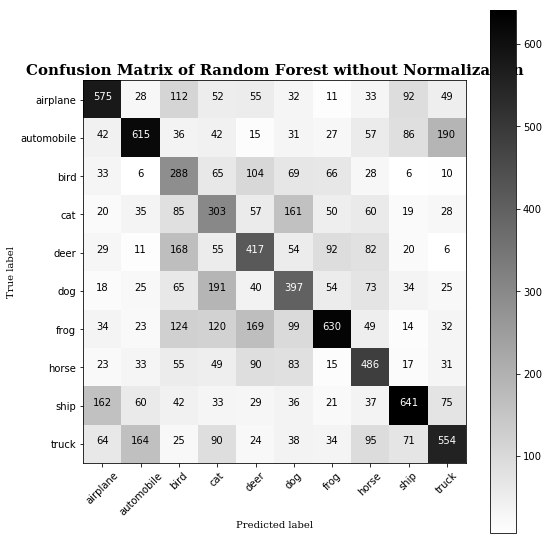

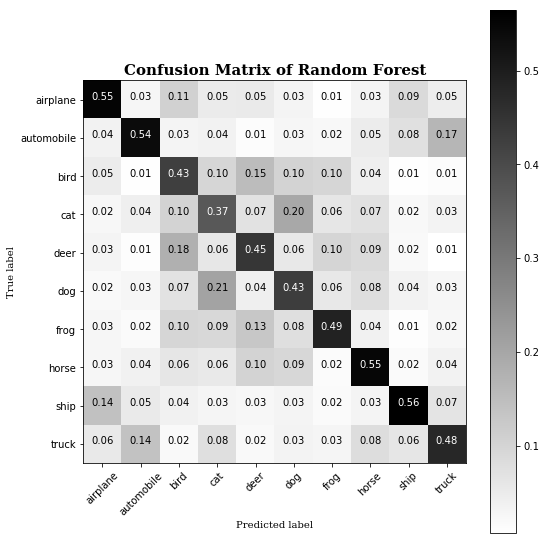

In [21]:
import itertools  
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_pred, test_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=False, 
                      title='Confusion Matrix of Random Forest without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=True, 
                      title='Confusion Matrix of Random Forest')

In [22]:
print(classification_report(test_labels, Y_pred, target_names=label_names))

             precision    recall  f1-score   support

   airplane       0.55      0.57      0.56      1000
 automobile       0.54      0.61      0.57      1000
       bird       0.43      0.29      0.34      1000
        cat       0.37      0.30      0.33      1000
       deer       0.45      0.42      0.43      1000
        dog       0.43      0.40      0.41      1000
       frog       0.49      0.63      0.55      1000
      horse       0.55      0.49      0.52      1000
       ship       0.56      0.64      0.60      1000
      truck       0.48      0.55      0.51      1000

avg / total       0.48      0.49      0.48     10000

